c:\Users\krtc0\anaconda3\envs\PyTorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\krtc0\anaconda3\envs\PyTorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\krtc0\anaconda3\envs\PyTorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\krtc0\anaconda3\envs\PyTorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\krtc0\anaconda3\envs\PyTorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}

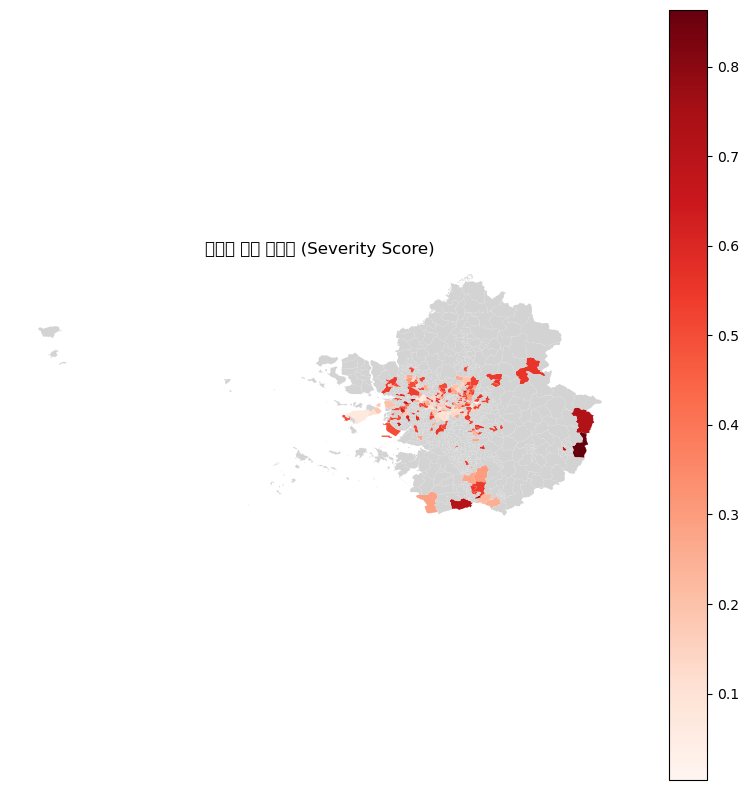

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


# 1. 데이터 로드
region_df = pd.read_csv(r"C:\Users\krtc0\OneDrive\문서\GitHub\sky-root-analysis\result\region\2024-08-19.csv")
emd = gpd.read_file(r"C:\Users\krtc0\OneDrive\문서\GitHub\sky-root-analysis\data\open\emd_WGS84.json")

# 2. 코드 타입 통일
region_df["EMD_CODE"] = region_df["EMD_CODE"].astype(int).astype(str)
emd["EMD_CD"] = emd["EMD_CD"].astype(str)

# 3. 조인
gdf = emd.merge(region_df, left_on="EMD_CD", right_on="EMD_CODE", how="left")

# 4. 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(
    column="severity_score",
    cmap="Reds",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey"}
)

ax.set_title("지역별 개선 필요도 (Severity Score)")
ax.axis("off")
plt.show()

In [2]:
# 2️⃣ 개선 필요 상위 3개 지역 선정

top3 = (
    region_df[region_df["improve_trips"] == True]
    .sort_values("severity_score", ascending=False)
    .head(3)
)

top3_codes = top3["EMD_CODE"].astype(str).tolist()

In [3]:
# 🗺️ Folium 기반 시각화 (추천 ⭐)

import folium
from shapely.geometry import LineString

m = folium.Map(location=[37.55, 126.98], zoom_start=12)

for top3_code in top3_codes:
# 기준 지역
    emd_target = gdf[gdf["EMD_CODE"] == top3_code]

    folium.GeoJson(
        emd_target.geometry,
        name=f"EMD {top3_code}",
        style_function=lambda x: {
            "fillColor": "none",
            "color": "red",
            "weight": 3
        }
    ).add_to(m)
    
folium.LayerControl().add_to(m)

In [4]:
# 🧍 실제 이동 경로 (파란 선)
trip_df = pd.read_csv(r"C:\Users\krtc0\OneDrive\문서\GitHub\sky-root-analysis\data\processed\2024-08-19.csv")

for top3_code in top3_codes:

    for trip_no, group in trip_df.groupby("TRIP_NO"):
        start_emd = group.iloc[0]["EMD_CODE"].astype(str)
        
        if start_emd != top3_code:
            continue   # 시작 EMD가 아니면 skip
        
        coords = list(zip(group["DPR_CELL_YCRD"], group["DPR_CELL_XCRD"]))
        
        folium.PolyLine(
            coords,
            color="blue",
            weight=2,
            opacity=0.6
        ).add_to(m)

C:\Users\krtc0\AppData\Local\Temp\ipykernel_5296\2771280326.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  trip_df = pd.read_csv(r"C:\Users\krtc0\OneDrive\문서\GitHub\sky-root-analysis\data\processed\2024-08-19.csv")


In [5]:
# # 🚌 버스 탑승 구간 (빨간 선)
# bus_segments = trip_df[trip_df["BUS_TYPE"].notna()]

# for trip_id, group in bus_segments.groupby("TRIP_NO"):
#     coords = list(zip(group["DPR_CELL_YCRD"], group["DPR_CELL_XCRD"]))
#     folium.PolyLine(
#         coords,
#         color="red",
#         weight=4,
#         opacity=0.8,
#         tooltip=group["BUS_NAME"].iloc[0]
#     ).add_to(m)

m.save("top3_region_route.html")